# **Applied Deep Learning Tutorial**

## **Transfer Learning for Object Classification**


### **Imports**

Import the necessary libraries and load the Dogs vs Cats dataset from Kaggle.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
#print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg



TensorFlow 1.x selected.


### **Preparing the data**

Create directories for training and validation for both classes, such as dog and cat.

In [3]:
# Load Cats vs Dogs dataset
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)

base_dir, _ = os.path.splitext(zip_file)
print(os.listdir(base_dir))
train_dir = os.path.join(base_dir, 'train')
print(os.listdir(train_dir))
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
#'''print how many cat images there are in your training dataset''

print('Train cats:' + str(len(os.listdir(train_cats_dir))))
print(os.listdir(train_cats_dir))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

print('Train dogs:' + str(len(os.listdir(train_dogs_dir))))
print(os.listdir(train_dogs_dir))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

print('Validation cats:' + str(len(os.listdir(validation_cats_dir))))
print(os.listdir(validation_cats_dir))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('Validation dogs:' + str(len(os.listdir(validation_dogs_dir))))
print(os.listdir(validation_dogs_dir))

68608000/68606236 [==============================] - 1s 0us/step
['validation', 'vectorize.py', 'train']
['cats', 'dogs']
Train cats:1000
['cat.76.jpg', 'cat.634.jpg', 'cat.445.jpg', 'cat.67.jpg', 'cat.40.jpg', 'cat.777.jpg', 'cat.355.jpg', 'cat.308.jpg', 'cat.221.jpg', 'cat.703.jpg', 'cat.766.jpg', 'cat.699.jpg', 'cat.55.jpg', 'cat.109.jpg', 'cat.323.jpg', 'cat.778.jpg', 'cat.145.jpg', 'cat.405.jpg', 'cat.309.jpg', 'cat.998.jpg', 'cat.834.jpg', 'cat.648.jpg', 'cat.574.jpg', 'cat.704.jpg', 'cat.795.jpg', 'cat.83.jpg', 'cat.233.jpg', 'cat.564.jpg', 'cat.167.jpg', 'cat.325.jpg', 'cat.836.jpg', 'cat.493.jpg', 'cat.277.jpg', 'cat.315.jpg', 'cat.732.jpg', 'cat.442.jpg', 'cat.34.jpg', 'cat.481.jpg', 'cat.43.jpg', 'cat.410.jpg', 'cat.905.jpg', 'cat.929.jpg', 'cat.260.jpg', 'cat.874.jpg', 'cat.230.jpg', 'cat.32.jpg', 'cat.597.jpg', 'cat.996.jpg', 'cat.21.jpg', 'cat.142.jpg', 'cat.479.jpg', 'cat.290.jpg', 'cat.845.jpg', 'cat.464.jpg', 'cat.948.jpg', 'cat.762.jpg', 'cat.161.jpg', 'cat.19.jpg', '

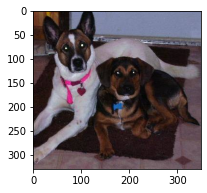

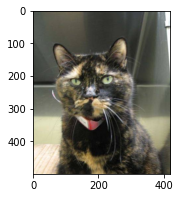

In [4]:
import cv2
import pandas as pd,numpy as np,pylab as pl
#n=np.random.randint(0,210,1)[0]
#print('Label: ',flower_labels[n],names[flower_labels[n]])
def show_img(img_dir: str) -> None:
  n=np.random.randint(0,499,1)[0]
  srcname = os.path.abspath(img_dir) +'/'+ os.listdir(img_dir)[n]
  img=cv2.imread(srcname)
  rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  pl.figure(figsize=(3,3))
  pl.imshow(rgb_img);

show_img(train_dogs_dir)
show_img(train_cats_dir)


Set up a pipeline for data augmentation with Keras

In [5]:
image_size = 200 # All images will be resized to 200x200
batch_size = 20

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### **Preparing pretrained model**

 The VGG16 model pre-trained on the ImageNet dataset

In [6]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


## **Feature Extraction without finetuning**
We will freeze the layers of the VGG16 and utilize the feature extractor capabilities of this part of the network.

In [7]:
feature_extractor.trainable = False #'''freeze the pretrained graph of the VGG16'''

# Let's take a look at the base model architecture (notice the amount of non-trainable params, what do you expect? And why?)
feature_extractor.summary()
# There are 14,714,688 non-trainable parameters and 0 trainable. We "froze" the model to use the already trained parameters

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
# tf.keras.utils.plot_model(feature_extractor)

In [8]:
#'''add a global 2D average pooling layer here, why do we need this?'''
'''Global Average Pooling calculates the average output of each feature map in the previous layer. 
GAP layer reduces each h×w feature map to a single number by simply taking the average of all hw values.
GAP reduces the data significantly (from 6x6x512 to 1x1x512) and prepares the model for the final classification layer.
''' 
# activation='softmax': constant : val_loss: 7.6246 - val_acc: 0.5000
model = tf.keras.Sequential([
  feature_extractor,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_vgg16_I")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 25 
# the pretrained model ckpt_training_vgg16 has been trained for: 
# 2  epochs reaching a validation accuracy of:0.9610
# 5  epochs reaching a validation accuracy of:0.9600
# 10  epochs reaching a validation accuracy of:0.9570
# 15  epochs reaching a validation accuracy of:0.9620
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

Epoch 1/25
100/100 [==============================] - 19s 186ms/step - loss: 0.4721 - acc: 0.7845 - val_loss: 0.3425 - val_acc: 0.8750
Epoch 2/25
100/100 [==============================] - 12s 117ms/step - loss: 0.3284 - acc: 0.8645 - val_loss: 0.2816 - val_acc: 0.9010
Epoch 3/25
100/100 [==============================] - 12s 118ms/step - loss: 0.2814 - acc: 0.8845 - val_loss: 0.2741 - val_acc: 0.8870
Epoch 4/25
100/100 [==============================] - 12s 119ms/step - loss: 0.2604 - acc: 0.8975 - val_loss: 0.2788 - val_acc: 0.8810
Epoch 5/25
100/100 [==============================] - 12s 118ms/step - loss: 0.2376 - acc: 0.9010 - val_loss: 0.2580 - val_acc: 0.8910
Epoch 6/25
100/100 [==============================] - 12s 119ms/step - loss: 0.2310 - acc: 0.9085 - val_loss: 0.2502 - val_acc: 0.8970
Epoch 7/25
100/100 [==============================] - 12s 118ms/step - loss: 0.2238 - acc: 0.9095 - val_loss: 0.2368 - val_acc: 0.8980
Epoch 8/25
100/100 [==============================] - 1

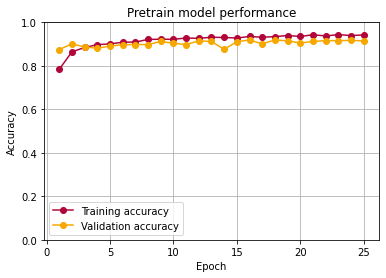

In [10]:
def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["acc"]
    y_test = history.history["val_acc"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)

plot_history('Pretrain model performance', history, 0)

## **Feature Extraction with finetuning**
We will freeze the layers of the VGG16 and utilize the feature extractor capabilities of this part of the network.

In [12]:
feature_extractor.trainable = True

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [14]:
#add a global 2D average pooling layer

model = tf.keras.Sequential([
  feature_extractor,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_vgg16_II")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 25 
# the pretrained model ckpt_training_vgg16 has been trained for: 
# 2  epochs reaching a validation accuracy of:0.9610
# 5  epochs reaching a validation accuracy of:0.9600
# 10  epochs reaching a validation accuracy of:0.9570
# 15  epochs reaching a validation accuracy of:0.9620
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history_II = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])



Epoch 1/25
100/100 [==============================] - 22s 221ms/step - loss: 31682047558134.9141 - acc: 0.5000 - val_loss: 4.9745 - val_acc: 0.5000
Epoch 2/25
100/100 [==============================] - 19s 195ms/step - loss: 2.0078 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/25
100/100 [==============================] - 20s 195ms/step - loss: 0.9605 - acc: 0.5190 - val_loss: 0.7008 - val_acc: 0.5000
Epoch 4/25
100/100 [==============================] - 19s 194ms/step - loss: 0.7001 - acc: 0.4960 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 5/25
100/100 [==============================] - 19s 194ms/step - loss: 0.7023 - acc: 0.4910 - val_loss: 0.6958 - val_acc: 0.5000
Epoch 6/25
100/100 [==============================] - 19s 193ms/step - loss: 0.7022 - acc: 0.4900 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 7/25
100/100 [==============================] - 19s 193ms/step - loss: 0.7085 - acc: 0.4980 - val_loss: 0.7052 - val_acc: 0.5000
Epoch 8/25
100/100 [======================

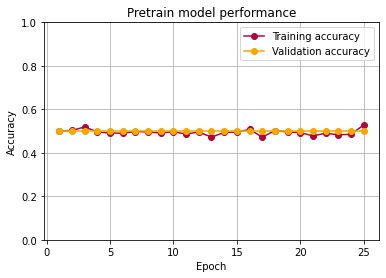

In [16]:
plot_history('Pretrain model performance', history_II, 0)